In [1]:
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import seaborn as sn
from sklearn.utils import shuffle           
import matplotlib.pyplot as plt         
import cv2                                 
import tensorflow as tf                
from tqdm import tqdm
import pandas as pd
from tensorflow.keras.callbacks import ModelCheckpoint
%matplotlib inline
from tensorflow.keras import models, layers, regularizers, Input
plt.rcParams["axes.grid"] = False
import keras

In [2]:
class_names = ['mountain', 'street', 'glacier', 'buildings', 'sea', 'forest']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

In [3]:
def model_plots(history,name):
    plt.style.use('ggplot')
    
    fig1, ax1 = plt.subplots(figsize=(6,6))
    metrics = ['acc','val_acc']
    for metric in metrics:
        ax1 = plt.plot(history.history[metric], label=metric)
    ax1 = plt.title(f'{name}-Accuracy')

    ax1 = plt.legend()
    ax1 = plt.tight_layout()
    ax1 = plt.xlabel('Epochs')
    ax1 = plt.ylabel('Accuracy')
    fig1.savefig(f'Images/metrics/{name}-accuracy.jpg',bbox_inches='tight', dpi=150)
    
    fig2, ax2 = plt.subplots(figsize=(6,6))
    metrics = ['loss','val_loss']
    for metric in metrics:
        ax2 = plt.plot(history.history[metric], label=metric)
    ax2 = plt.title(f'{name}-Loss')

    ax2 = plt.legend()
    ax2 = plt.tight_layout()
    ax2 = plt.xlabel('Epochs')
    ax2 = plt.ylabel('Loss')
    fig2.savefig(f'Images/metrics/{name}-loss.jpg',bbox_inches='tight', dpi=150)

In [4]:
test_clustered = np.load('../../../../Datasets/clusted_images_test.npz')['args']
train_clustered = np.load('../../../../Datasets/clusted_images_train.npz')['args']
test_clustered_labels = np.load('../../../../Datasets/test_labels.npz')['args']
train_clustered_labels = np.load('../../../../Datasets/train_labels.npz')['args']

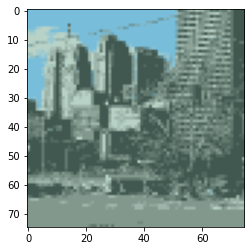

In [5]:
plt.imshow(cv2.resize(test_clustered[1],(75,75)))

In [6]:
test_clustered.shape

(3000, 150, 150, 3)

In [7]:

test_clustered_reshaped = np.full((3000,75,75,3),None)
for i in range(0,3000,1):
    test_clustered_reshaped[i] = cv2.resize(test_clustered[1],(75,75))

In [8]:
test_clustered_reshaped.shape

(3000, 75, 75, 3)

In [9]:
def reshaper(array_of_imgs,size):
    new_shape = np.full((len(array_of_imgs),75,75,3),None)
    for i in range(0,len(array_of_imgs),1):
        new_shape[i] = cv2.resize(array_of_imgs[i],size)
    return new_shape

In [10]:
test_clustered_reshaped = reshaper(test_clustered,(75,75)).astype('float32')
train_clustered_reshaped = reshaper(train_clustered,(75,75)).astype('float32')

In [11]:
test_clustered_reshaped.dtype

dtype('float32')

In [12]:
def model_plots(history,name):
    plt.style.use('ggplot')
    
    fig1, ax1 = plt.subplots(figsize=(6,6))
    metrics = ['acc','val_acc']
    for metric in metrics:
        ax1 = plt.plot(history.history[metric], label=metric)
    ax1 = plt.title(f'{name}-Accuracy')

    ax1 = plt.legend()
    ax1 = plt.tight_layout()
    ax1 = plt.xlabel('Epochs')
    ax1 = plt.ylabel('Accuracy')
    fig1.savefig(f'Images/{name}-accuracy.jpg',bbox_inches='tight', dpi=150)
    
    fig2, ax2 = plt.subplots(figsize=(6,6))
    metrics = ['loss','val_loss']
    for metric in metrics:
        ax2 = plt.plot(history.history[metric], label=metric)
    ax2 = plt.title(f'{name}-Loss')

    ax2 = plt.legend()
    ax2 = plt.tight_layout()
    ax2 = plt.xlabel('Epochs')
    ax2 = plt.ylabel('Loss')
    fig2.savefig(f'Images/{name}-loss.jpg',bbox_inches='tight', dpi=150)

In [13]:
layers_list = []

def modeler(layers_list,dims):
    
    model = models.Sequential()
    model.add(layers.InputLayer(dims))
    #     model.add(layers.Conv2D(128,(3,3),activation='relu',input_shape=(75, 75, 3)))
    #     model.add(layers.Conv2D(128,(3,3),activation='relu'))

    
    for layer in layers_list:
        model.add(layer)
    
    model.add(layers.Flatten())
    model.add(layers.Dense(128,activation='relu'))
    model.add(layers.Dense(6,activation='softmax'))
    
    
 
    return model

In [42]:
def model_trainer(model,name,train_img,train_labels,test_img,test_labels,batch_size=16,epochs=5,summary=False):
    
    model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['acc'])
    
    if summary:
        return model.summary()
    
    checkpoint = tf.keras.callbacks.ModelCheckpoint(f'../../../../Models/{name}_model.h5', save_best_only=True)
    earlystop = tf.keras.callbacks.EarlyStopping(
                                monitor='val_loss', # What to watch
                                min_delta=0.1, # How much change to get
                                patience=5 # No change after 5 epochs
    )
    history = model.fit(train_img,train_labels,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(test_img,test_labels),
                    callbacks=[checkpoint,earlystop])
    
    return history

In [91]:
layers_list = [layers.Conv2D(128,(3,3),activation='relu',input_shape=(75, 75, 3)),
               layers.MaxPooling2D(2,2),
               layers.Dropout(0.2),
               layers.Conv2D(128,(3,3),activation='relu',kernel_regularizer=regularizers.l2(l2=0.15))
               ]

model = modeler(layers_list,(75,75,3))

In [92]:
history = model_trainer(model,'3rd-color_comp',
                        train_clustered_reshaped,train_clustered_labels,
                        test_clustered_reshaped,test_clustered_labels,
                        batch_size=32,
                        epochs=5,
                        summary=False)

Epoch 1/5
439/439 [==============================] - 203s 463ms/step - loss: 2.1722 - acc: 0.5692 - val_loss: 0.9878 - val_acc: 0.6493
Epoch 2/5
439/439 [==============================] - 202s 459ms/step - loss: 0.9340 - acc: 0.6599 - val_loss: 0.8619 - val_acc: 0.6903
Epoch 3/5
439/439 [==============================] - 201s 458ms/step - loss: 0.8559 - acc: 0.6961 - val_loss: 0.8813 - val_acc: 0.6893
Epoch 4/5
439/439 [==============================] - 201s 458ms/step - loss: 0.7908 - acc: 0.7193 - val_loss: 0.8032 - val_acc: 0.7247
Epoch 5/5
439/439 [==============================] - 200s 455ms/step - loss: 0.7446 - acc: 0.7425 - val_loss: 0.8187 - val_acc: 0.7063


In [93]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_34 (Conv2D)           (None, 73, 73, 128)       3584      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 36, 36, 128)       0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 36, 36, 128)       0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 34, 34, 128)       147584    
_________________________________________________________________
flatten_12 (Flatten)         (None, 147968)            0         
_________________________________________________________________
dense_35 (Dense)             (None, 128)               18940032  
_________________________________________________________________
dense_36 (Dense)             (None, 6)               

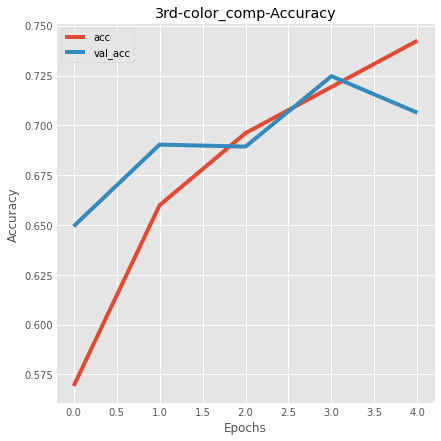

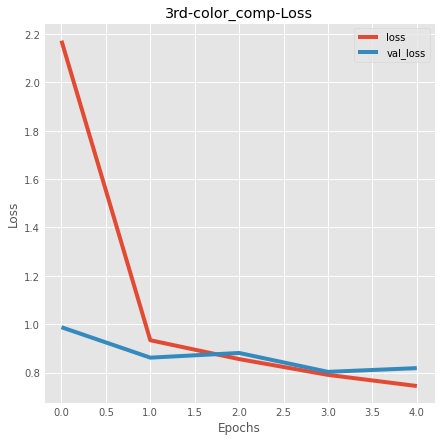

In [94]:
model_plots(history,'3rd-color_comp')

In [95]:
import lime
plt.rcParams["axes.grid"] = False


In [96]:
from lime import lime_image
from skimage.segmentation import mark_boundaries

In [97]:
import random

In [123]:
def image_expl(model,image_array,name,image_label):
    '''
    Takes a model, single image array, name string of the model, and the true label of the image.
    Uses LIME to get an image explainer and plots the image and explaination.
    '''
    
    fig, ax = plt.subplots()
    #instantiate explainer
    explainer = lime_image.LimeImageExplainer(random_state=1)
    #explain an image caste to double bc updated keras version, pass predictor 
    explanation = explainer.explain_instance(image_array.astype('double'), model.predict)
    #show the image
    ax = plt.imshow(image_array)
    #get the mask for the prediction
    temp, mask = explanation.get_image_and_mask(model.predict(image_array.reshape((1,75,75,3))).argmax(axis=1)[0], positive_only=True, hide_rest=False)
    #show image and mask together
    ax = plt.imshow(mark_boundaries(temp, mask))
    
    ax = plt.title(f'{name}-{label}')
    


    fig.savefig(f'Images/explainer/{name}-{label}.jpg',bbox_inches='tight', dpi=150)

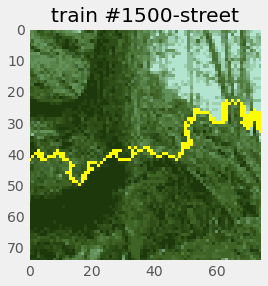

In [124]:
image_expl(model,test_clustered_reshaped[500],'train #1500',test_clustered_labels[500])

In [125]:
def image_preds(model,image_array,name,image_label):
    '''
    Takes a model, single image array, name string of the model, and the true label of the image.
    Plots the class predictions for the image.
    '''
    plt.style.use('fivethirtyeight')
    plt.rcParams["axes.grid"] = False

    fig, ax = plt.subplots(figsize=(6,6))
    ax = plt.plot(range(0,6),model.predict(image_array.reshape((1,75,75,3)))[0])
    ax = plt.xticks(ticks=[0,1,2,3,4,5],labels=class_names)
    ax = plt.tight_layout()
    ax = plt.xlabel('Class Name')
    ax = plt.ylabel('Confidence')
    ax = plt.title(f'{name}-{label}')
    fig.savefig(f'Images/preds/{name}-{label}-preds.jpg',bbox_inches='tight', dpi=150)

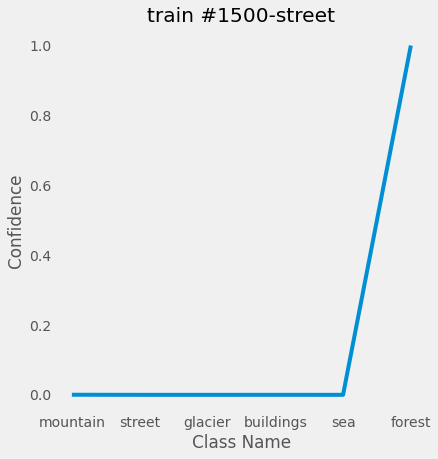

In [126]:
image_preds(model,test_clustered_reshaped[500],'train #1500',test_clustered_labels[500])

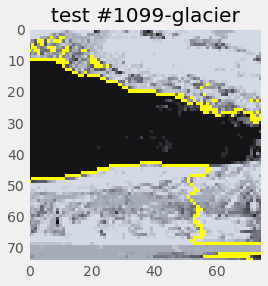

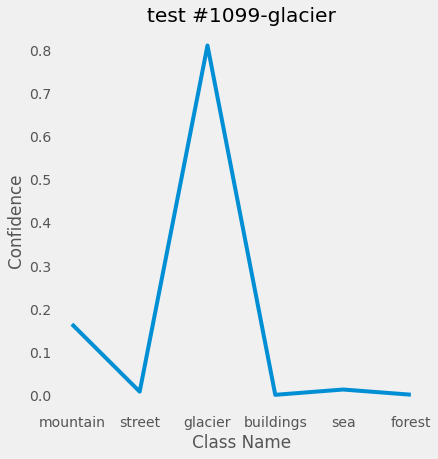

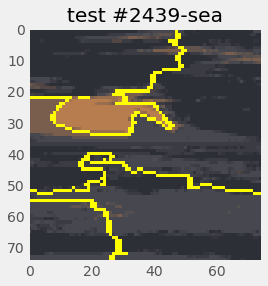

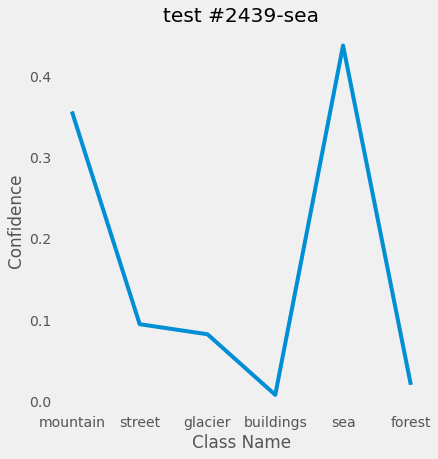

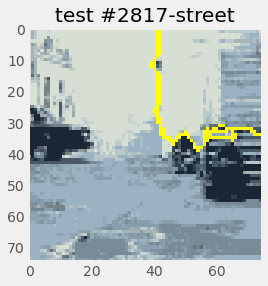

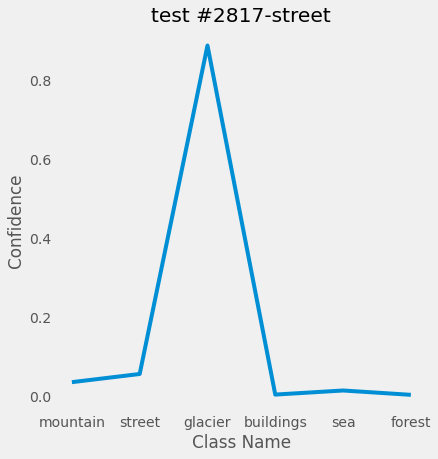

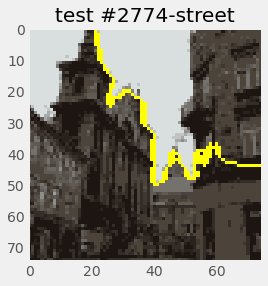

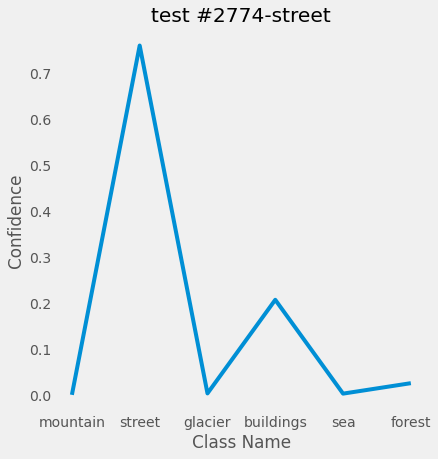

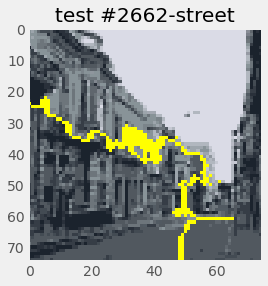

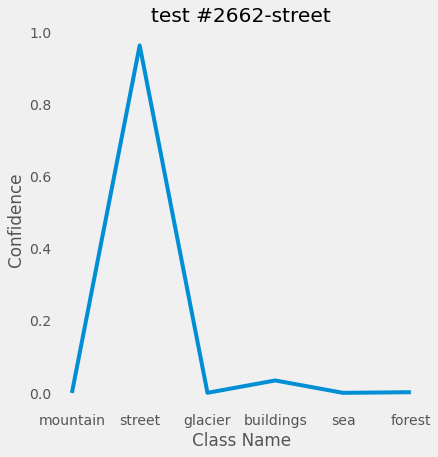

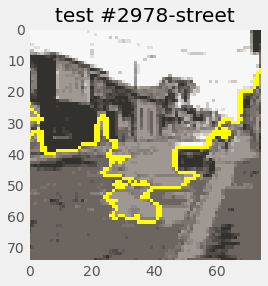

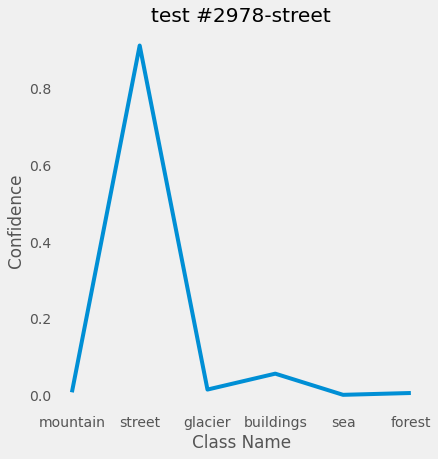

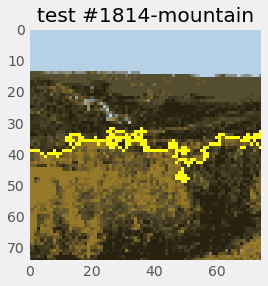

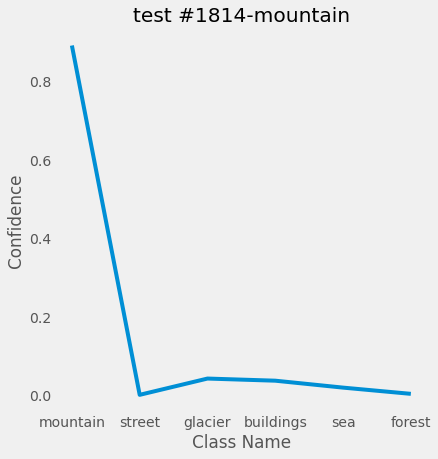

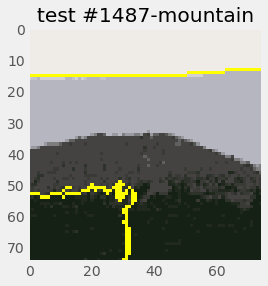

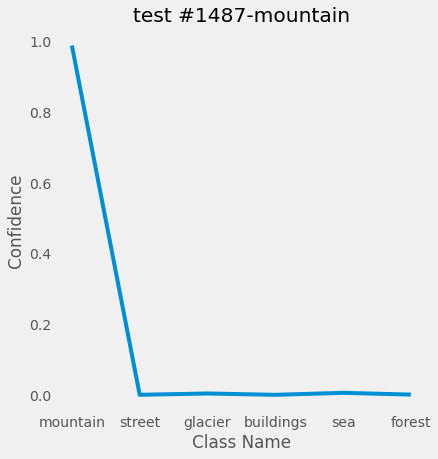

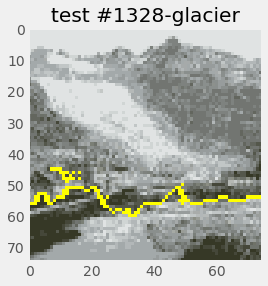

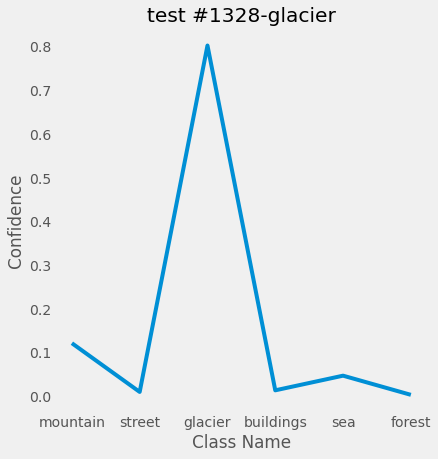

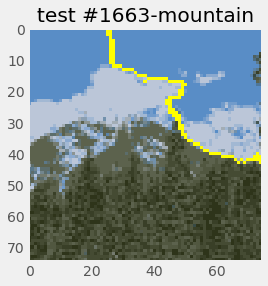

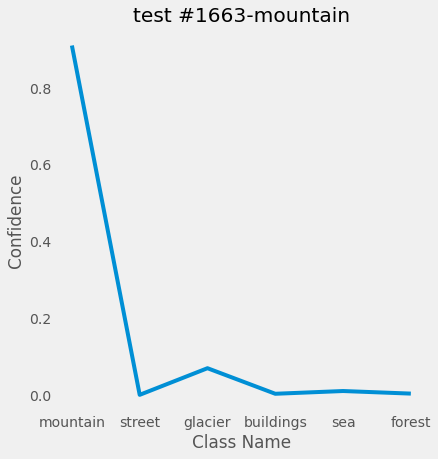

In [127]:
rand_img = np.random.randint(0,3000,10)
class_map = {0:'mountain',1:'street',2:'glacier',3:'buildings',4:'sea',5:'forest'}

for num in rand_img:
    label = class_map[test_clustered_labels[num]]
    image_expl(model,test_clustered_reshaped[num],f'test #{num}',label)
    image_preds(model,test_clustered_reshaped[num],f'test #{num}',label)